# Recomendador de películas

En este notebook se prepararán los datos y se construirá el modelo para crear un motor de recomendaciones basado en contenidos.

Este es el diagrama del modelo 3.

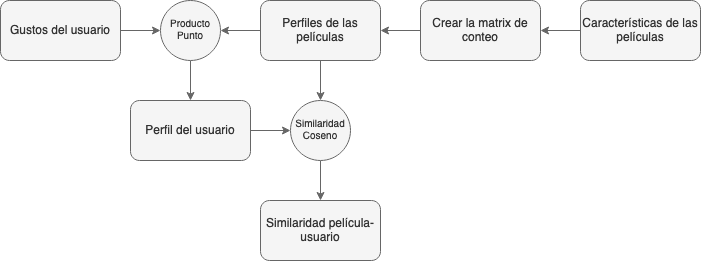


In [375]:
import pandas as pd
import os
import numpy as np
import scipy
import sklearn
import json
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics.pairwise import linear_kernel

In [376]:
FILES_PATH = "../data"

df_raw_movies=pd.read_csv(os.path.join(FILES_PATH, 'movies.csv'))
df_raw_user_likes =pd.read_csv(os.path.join(FILES_PATH, 'user_likes.csv'))

display(df_raw_movies.head(2))
display(df_raw_user_likes.head(2))

RatingIMDB  Year     imdbID  Metascore  Episode       Director  \
0         7.8  1987  tt0092603        NaN      NaN   Gabriel Axel   
1         6.7  1995  tt0112857       78.0      NaN  Carl Franklin   

                                              Writer  \
0  Karen Blixen (short story), Gabriel Axel (scre...   
1   Walter Mosley (book), Carl Franklin (screenplay)   

                                                Plot  \
0  During the late 19th century, a strict religio...   
1  An African-American man is hired to find a wom...   

                                             Ratings Rated  ...     Released  \
0  [{'Value': '7.8/10', 'Source': 'Internet Movie...     G  ...  04 Mar 1988   
1  [{'Value': '6.7/10', 'Source': 'Internet Movie...     R  ...  29 Sep 1995   

   Runtime          DVD                                   Language  \
0  103 min          NaN  Danish, French, Swedish, Italian, English   
1  102 min  09 Mar 1999                                    English   

                             Genre imdbRating imdbVotes Website  totalSeasons  \
0                            Drama        7.8    17,150     NaN           NaN   
1  Crime, Drama, Mystery, Thriller        6.7    16,636     NaN           NaN   

   Country  
0  Denmark  
1      USA  

[2 rows x 30 columns]

user_email                                              likes
0      user1  ['tt0166924', 'tt0211915', 'tt0120737', 'tt024...
1      user2  ['tt0298130', 'tt0278504', 'tt0316188', 'tt021...

## Limpiar los datos

In [377]:
def comma_to_list(x):
    if isinstance(x, str):
        return x.split(",")
    return x

features = ['Actors', 'Genre', 'Writer']
df_comma_separated_movies = df_raw_movies
for feature in features:
    df_comma_separated_movies[feature] = df_raw_movies[feature].apply(comma_to_list)
    
df_comma_separated_movies.head(2)

RatingIMDB  Year     imdbID  Metascore  Episode       Director  \
0         7.8  1987  tt0092603        NaN      NaN   Gabriel Axel   
1         6.7  1995  tt0112857       78.0      NaN  Carl Franklin   

                                              Writer  \
0  [Karen Blixen (short story),  Gabriel Axel (sc...   
1  [Walter Mosley (book),  Carl Franklin (screenp...   

                                                Plot  \
0  During the late 19th century, a strict religio...   
1  An African-American man is hired to find a wom...   

                                             Ratings Rated  ...     Released  \
0  [{'Value': '7.8/10', 'Source': 'Internet Movie...     G  ...  04 Mar 1988   
1  [{'Value': '6.7/10', 'Source': 'Internet Movie...     R  ...  29 Sep 1995   

   Runtime          DVD                                   Language  \
0  103 min          NaN  Danish, French, Swedish, Italian, English   
1  102 min  09 Mar 1999                                    English   

                                  Genre imdbRating imdbVotes Website  \
0                               [Drama]        7.8    17,150     NaN   
1  [Crime,  Drama,  Mystery,  Thriller]        6.7    16,636     NaN   

   totalSeasons  Country  
0           NaN  Denmark  
1           NaN      USA  

[2 rows x 30 columns]

In [378]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        
features = ['Actors', 'Genre', 'Writer']
df_clean_movies = df_comma_separated_movies
for feature in features:
    df_clean_movies[feature] = df_comma_separated_movies[feature].apply(clean_data)

df_clean_movies['Plot'] = df_clean_movies['Plot'].fillna('')
df_clean_movies.head(2)

RatingIMDB  Year     imdbID  Metascore  Episode       Director  \
0         7.8  1987  tt0092603        NaN      NaN   Gabriel Axel   
1         6.7  1995  tt0112857       78.0      NaN  Carl Franklin   

                                              Writer  \
0  [karenblixen(shortstory), gabrielaxel(screenpl...   
1     [waltermosley(book), carlfranklin(screenplay)]   

                                                Plot  \
0  During the late 19th century, a strict religio...   
1  An African-American man is hired to find a wom...   

                                             Ratings Rated  ...     Released  \
0  [{'Value': '7.8/10', 'Source': 'Internet Movie...     G  ...  04 Mar 1988   
1  [{'Value': '6.7/10', 'Source': 'Internet Movie...     R  ...  29 Sep 1995   

   Runtime          DVD                                   Language  \
0  103 min          NaN  Danish, French, Swedish, Italian, English   
1  102 min  09 Mar 1999                                    English   

                               Genre imdbRating imdbVotes Website  \
0                            [drama]        7.8    17,150     NaN   
1  [crime, drama, mystery, thriller]        6.7    16,636     NaN   

   totalSeasons  Country  
0           NaN  Denmark  
1           NaN      USA  

[2 rows x 30 columns]

In [379]:
df_movies = df_clean_movies[["Director", "Writer", "Plot", "Actors", "Genre", "Title", "imdbID"]]
df_movies.head(2)

Director                                             Writer  \
0   Gabriel Axel  [karenblixen(shortstory), gabrielaxel(screenpl...   
1  Carl Franklin     [waltermosley(book), carlfranklin(screenplay)]   

                                                Plot  \
0  During the late 19th century, a strict religio...   
1  An African-American man is hired to find a wom...   

                                              Actors  \
0  [stéphaneaudran, bodilkjer, birgittefederspiel...   
1  [denzelwashington, tomsizemore, jenniferbeals,...   

                               Genre                  Title     imdbID  
0                            [drama]        Babette's Feast  tt0092603  
1  [crime, drama, mystery, thriller]  Devil in a Blue Dress  tt0112857

## Prepare user data

In [380]:
def convert_json(j):
    return json.loads(j.replace("'", '"').replace("None", "null"))

df_user_likes = df_raw_user_likes
df_user_likes['likes'] = df_raw_user_likes['likes'].apply(convert_json)
df_user_likes.head(2)

user_email                                              likes
0      user1  [tt0166924, tt0211915, tt0120737, tt0245429, t...
1      user2  [tt0298130, tt0278504, tt0316188, tt0217505, t...

## Primer modelo, similitud entre tramas

In [381]:
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_movies['Plot'])

# Peliculas, Caracteristicas
tfidf_matrix.shape

(2651, 9916)

In [382]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(df_movies.index, index=df_movies['Title']).drop_duplicates()

In [383]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim, n=10):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:n+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_movies[["Title", "imdbID"]].iloc[movie_indices]

In [384]:
get_recommendations('The Dark Knight Rises')

Title     imdbID
1414                                      Batman Begins  tt0372784
2003                                    The Dark Knight  tt0468569
1242                                             Batman  tt0096895
2171                                              Joker  tt7286456
2362                                                Jîn  tt2670226
1991                                          Elizabeth  tt0127536
2610                                         Peppermint  tt6850820
2058                                    The Incredibles  tt0317705
1605  Birds of Prey: And the Fantabulous Emancipatio...  tt7713068
2339                                   Marie Antoinette  tt0422720

In [385]:
get_recommendations('Catch Me If You Can')

Title     imdbID
1480                A Simple Plan  tt0120324
1751                   Wind River  tt5362988
1181                Donnie Brasco  tt0119008
382           Brewster's Millions  tt0088850
879           In the Line of Fire  tt0107206
1330  The House on Carroll Street  tt0095333
2598                   The Hidden  tt0093185
2560               The Best Offer  tt1924396
755                My Blue Heaven  tt0100212
1205                      Sicario  tt3397884

## Segundo modelo

Incluir más características

In [386]:
def create_soup(x):
    return str(x['Director']) + ' ' + ' '.join(x['Writer']) + ' ' + x['Plot'] + ' ' + ' '.join(x['Genre']) + ' ' + ' '.join(x['Actors'])

df_movies['soup'] = df_movies.apply(create_soup, axis=1)
df_movies.head(2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Director                                             Writer  \
0   Gabriel Axel  [karenblixen(shortstory), gabrielaxel(screenpl...   
1  Carl Franklin     [waltermosley(book), carlfranklin(screenplay)]   

                                                Plot  \
0  During the late 19th century, a strict religio...   
1  An African-American man is hired to find a wom...   

                                              Actors  \
0  [stéphaneaudran, bodilkjer, birgittefederspiel...   
1  [denzelwashington, tomsizemore, jenniferbeals,...   

                               Genre                  Title     imdbID  \
0                            [drama]        Babette's Feast  tt0092603   
1  [crime, drama, mystery, thriller]  Devil in a Blue Dress  tt0112857   

                                                soup  
0  Gabriel Axel karenblixen(shortstory) gabrielax...  
1  Carl Franklin waltermosley(book) carlfranklin(...

In [387]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_movies['soup'])

# Peliculas, Caracteristicas
count_matrix.shape

(2651, 22300)

In [388]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

df_movies = df_movies.reset_index()
indices = pd.Series(df_movies.index, index=df_movies['Title']).drop_duplicates()
# reverrse mapping
#indices = pd.Series(clean_df.index, index=clean_df['imdbID'])

In [389]:
display(get_recommendations('The Dark Knight Rises', cosine_sim2))

Title     imdbID
1414                            Batman Begins  tt0372784
2003                          The Dark Knight  tt0468569
2210                                   Tarzan  tt0120855
2057                        National Treasure  tt0368891
148                                 Megaforce  tt0084316
1242                                   Batman  tt0096895
2429                             Man of Steel  tt0770828
348   Night at the Museum: Secret of the Tomb  tt2692250
1031                           Back to School  tt0090685
488                                  Godzilla  tt0120685

Title     imdbID
1181            Donnie Brasco  tt0119008
2115                 The Dirt  tt0800325
1823            The Hurricane  tt0174856
427               Patch Adams  tt0129290
2618  The Wolf of Wall Street  tt0993846
1143       Heaven Is for Real  tt1929263
1435           Public Enemies  tt1152836
1053                    Bully  tt0242193
2000         Schindler's List  tt0108052
471                 Apollo 13  tt0112384

## Tercer modelo

Crear el perfil del usuario con producto punto

In [390]:
all_movies = [row["imdbID"] for index, row in df_movies.iterrows()]
all_users = [r['user_email'] for _, r in df_user_likes.iterrows()]
    
data = []
for index, row in df_user_likes.iterrows():
    for imdbid in row["likes"]:
        if imdbid:
            data.append([row["user_email"], imdbid])

user_activity = pd.DataFrame(data, index=range(len(data)), columns=['user_email', 'imdbID'])
s_length = len(user_activity['imdbID'])
user_activity['rating'] = pd.Series(np.ones((s_length,)), index=user_activity.index)

display(user_activity)

ratmat = user_activity.pivot(index='user_email', columns='imdbID',
            values='rating').fillna(0)
display(ratmat)

user_email     imdbID  rating
0        user1  tt0166924     1.0
1        user1  tt0211915     1.0
2        user1  tt0120737     1.0
3        user1  tt0245429     1.0
4        user1  tt0332452     1.0
..         ...        ...     ...
388     user13  tt0317705     1.0
389     user13  tt3606756     1.0
390     user13  tt1727824     1.0
391     user13  tt5463162     1.0
392     user13  tt1596363     1.0

[393 rows x 3 columns]

imdbID      tt0120737  tt0120903  tt0120917  tt0121766  tt0126029  tt0144084  \
user_email                                                                     
user1             1.0        1.0        0.0        0.0        0.0        1.0   
user10            0.0        0.0        0.0        0.0        0.0        0.0   
user11            0.0        0.0        0.0        0.0        0.0        0.0   
user12            0.0        0.0        0.0        1.0        0.0        0.0   
user13            0.0        0.0        0.0        0.0        0.0        0.0   
user2             0.0        0.0        0.0        0.0        0.0        0.0   
user3             1.0        0.0        1.0        0.0        1.0        0.0   
user4             0.0        0.0        0.0        0.0        0.0        0.0   
user5             1.0        1.0        0.0        1.0        1.0        1.0   
user6             0.0        0.0        0.0        0.0        0.0        0.0   
user7             1.0        0.0        0.0        1.0        0.0        0.0   
user8             0.0        0.0        0.0        0.0        0.0        0.0   
user9             0.0        0.0        0.0        0.0        0.0        0.0   

imdbID      tt0145487  tt0162222  tt0166924  tt0167260  ...  tt7286456  \
user_email                                              ...              
user1             0.0        1.0        1.0        0.0  ...        1.0   
user10            0.0        0.0        0.0        0.0  ...        0.0   
user11            0.0        0.0        0.0        0.0  ...        0.0   
user12            0.0        0.0        0.0        0.0  ...        0.0   
user13            0.0        0.0        0.0        0.0  ...        0.0   
user2             0.0        0.0        0.0        0.0  ...        0.0   
user3             0.0        0.0        0.0        1.0  ...        1.0   
user4             0.0        0.0        0.0        0.0  ...        0.0   
user5             1.0        0.0        0.0        1.0  ...        1.0   
user6             0.0        0.0        0.0        0.0  ...        0.0   
user7             0.0        1.0        0.0        1.0  ...        1.0   
user8             0.0        0.0        1.0        0.0  ...        0.0   
user9             0.0        0.0        0.0        0.0  ...        0.0   

imdbID      tt7984734  tt7984766  tt8291806  tt8367814  tt8579674  tt8772262  \
user_email                                                                     
user1             1.0        0.0        1.0        0.0        1.0        1.0   
user10            0.0        0.0        0.0        0.0        0.0        0.0   
user11            0.0        0.0        0.0        0.0        0.0        0.0   
user12            0.0        0.0        0.0        0.0        0.0        0.0   
user13            0.0        0.0        0.0        0.0        0.0        0.0   
user2             0.0        0.0        0.0        0.0        0.0        0.0   
user3             0.0        0.0        0.0        0.0        0.0        0.0   
user4             0.0        0.0        0.0        0.0        0.0        0.0   
user5             0.0        1.0        0.0        1.0        1.0        1.0   
user6             0.0        0.0        0.0        0.0        0.0        0.0   
user7             1.0        0.0        0.0        0.0        1.0        0.0   
user8             0.0        0.0        0.0        0.0        0.0        0.0   
user9             0.0        0.0        0.0        0.0        0.0        1.0   

imdbID      tt8946378  tt9048840  tt9243946  
user_email                                   
user1             1.0        0.0        0.0  
user10            0.0        0.0        0.0  
user11            0.0        0.0        0.0  
user12            0.0        0.0        0.0  
user13            0.0        0.0        0.0  
user2             0.0        0.0        0.0  
user3             0.0        0.0        0.0  
user4             0.0        0.0        0.0  
user5             0.0      

In [391]:
movies_used = df_movies[df_movies['imdbID'].isin(user_activity['imdbID'].tolist())]
print(movies_used.shape)
count = CountVectorizer(stop_words='english')
x = count.fit_transform(movies_used['soup'])
count_matrix = x.todense()

from scipy import linalg, dot
print(ratmat.shape, count_matrix.shape)


userprof = dot(ratmat,count_matrix) / linalg.norm(ratmat) / linalg.norm(count_matrix)

(229, 9)
(13, 229) (229, 3604)


In [392]:
import sklearn.metrics
similarityCalc = sklearn.metrics.pairwise.cosine_similarity(userprof, count_matrix, dense_output=True)

final_pred= np.where(similarityCalc>0.4, 1, 0)
indexes_of_user = np.where(final_pred[1] == 1)
display(indexes_of_user)

(array([40, 45, 53, 69]),)

In [393]:
for i, user in enumerate(all_users):
    display(df_user_likes.iloc[i])
    indexes_of_user = np.where(final_pred[i] == 1)
    for iu in indexes_of_user:
        display(df_movies[["Title", "imdbID"]].iloc[iu])

user_email                                                user1
likes         [tt0166924, tt0211915, tt0120737, tt0245429, t...
Name: 0, dtype: object

Empty DataFrame
Columns: [Title, imdbID]
Index: []

user_email                                                user2
likes         [tt0298130, tt0278504, tt0316188, tt0217505, t...
Name: 1, dtype: object

Title     imdbID
40                Presto  tt1245104
45  Stuck in the Suburbs  tt0410696
53            The Caller  tt0097007
69        Mother and Son  tt0119711

user_email                                                user3
likes         [tt0332452, tt0338013, tt0317705, tt0304141, t...
Name: 2, dtype: object

Title     imdbID
136   Ruthless People  tt0091877
142          Valkyrie  tt0985699
178  The Color Purple  tt0088939
195            Hesher  tt1403177

user_email                                user4
likes         [tt6343314, tt5052474, tt4154756]
Name: 3, dtype: object

Title     imdbID
3                         Crumb  tt0109508
65            L.A. Confidential  tt0119488
73   How to Train Your Dragon 2  tt1646971
123                    Trespass  tt1674784

user_email                                                user5
likes         [tt9048840, tt0332452, tt0316654, tt0338013, t...
Name: 4, dtype: object

Title     imdbID
40                 Presto  tt1245104
45   Stuck in the Suburbs  tt0410696
131          Café Society  tt4513674
139             Long Shot  tt2139881
185          Urban Cowboy  tt0081696

user_email                                                user6
likes         [tt0338013, tt3460252, tt1392190, tt0206634, t...
Name: 5, dtype: object

Title     imdbID
21              Moonlight  tt4975722
22    Saving Private Ryan  tt0120815
35  Promising Young Woman  tt9620292
38          Naked Harbour  tt1787767
43       Burden of Dreams  tt0083702

user_email                                                user7
likes         [tt3896198, tt5013056, tt3315342, tt0121766, t...
Name: 6, dtype: object

Title     imdbID
27            Wag the Dog  tt0120885
68          Man Bites Dog  tt0103905
161  Sleepless in Seattle  tt0108160
194              The Ring  tt0298130
195                Hesher  tt1403177

user_email                     user8
likes         [tt0166924, tt0245429]
Name: 7, dtype: object

Title     imdbID
193  Carlito's Way  tt0106519
205      Star Trek  tt0796366
215          Titus  tt0120866

user_email                                                user9
likes         [tt3315342, tt0309987, tt1318514, tt8772262, t...
Name: 8, dtype: object

Empty DataFrame
Columns: [Title, imdbID]
Index: []

user_email                                               user10
likes         [tt0304141, tt0317705, tt0338013, tt5463162, t...
Name: 9, dtype: object

Title     imdbID
44   Letters to Father Jacob  tt1364487
53                The Caller  tt0097007
120          Despicable Me 3  tt3469046
195                   Hesher  tt1403177
206               Ex Drummer  tt0812243

user_email                                               user11
likes         [tt0317705, tt0338013, tt0304141, tt0451279, t...
Name: 10, dtype: object

Empty DataFrame
Columns: [Title, imdbID]
Index: []

user_email         user12
likes         [tt0121766]
Name: 11, dtype: object

Title     imdbID
8          The Blair Witch Project  tt0185937
24  An American Werewolf in London  tt0082010

user_email                                               user13
likes         [tt7146812, tt0304141, tt0317705, tt3606756, t...
Name: 12, dtype: object

Title     imdbID
11   Fast, Cheap & Out of Control  tt0119107
41                 American Honey  tt3721936
65              L.A. Confidential  tt0119488
73     How to Train Your Dragon 2  tt1646971
85                    The Hitcher  tt0091209
123                      Trespass  tt1674784
178              The Color Purple  tt0088939